# scikit-learn

## Overview

Scikit-learn [R] is a Python package containing a wide selection of tools for machine learning. Machine learning is a technique of using computers to make predictions on unseen data based on either previously seen data or algorithms which find patterns within data. In addition to a large collection of data analysis algorithms, the package also provides tools for data preprocessing and dimensionality reduction; model selection and hyperparameter tuning - that is, finding an algorithm and a set of parameters to that algorithm that enable it to best perform on a particular dataset.

1. Organisation of package

One of the most remarkable attributes of the scikit-learn package is its design philosophy. In addition to providing a huge array of algorithms and models, it provides a consistent interface and sensible defaults so it is possible to drop replacement algorithms into different parts of a preprocessing-fitting-predicting-assessing pipeline with minimal work, even with very little knowledge of the internal workings of those algorithms. Because of this it is very easy to get a basic classification 
1. Consistent API -- `transform()`, `fit()`, `fit_transform()`, `predict`, etc
1. Pipelines and Grid / Randomised search



## Imports

The following code cells import all the libraries necessary to run this notebook. As there are a lot of imports, they are divided into four cells according to their function for easier management. 

In [3]:
# General utilities

# file management
import os
# downloading datasets
import requests
# url construction
from urllib.parse import urljoin
# quick tables
from tabulate import tabulate
# like zip but doesn't truncate if one list is longer
from itertools import zip_longest
from IPython.display import display


In [4]:
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Data manipulation
import pandas as pd
import numpy as np

In [60]:
# from sklearnex import patch_sklearn, unpatch_sklearn
# patch_sklearn()

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.model_selection import cross_val_predict

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

from category_encoders import TargetEncoder
from category_encoders.ordinal import OrdinalEncoder

from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

## The Wine Quality Dataset
The wine quality dataset, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/), consists of two semicolon-delimited files, one relating to Portuguese *Vinho Verde* red wines and one to whites. The datasets were produced by Cortez et al.[1] in order to assess various machine learning algorithms in prediction of the quality of a wine from its properties. They considered support vector machines (SVM), multiple regression analysis, and neural networks. Of these the best performance was achieved using SVM [-1, 0].

Twelve attributes are recorded for each wine sample; eleven are objective physical or chemical attributes, and one, `quality`, is a subjective assessment of the wine's quality. The `quality` attribute is recorded as a value from 0 (poorest quality) to 10 (best quality) and is derived from the median score assigned to it by at least three experts.

The data information sheet distributed with the data [0] notes that several attributes may be correlated and that not all attributes necessarily affect quality and suggests that feature selection may be advisable. The datasheet also suggests that the problem of wine quality prediction may be cast as a regression problem or as a classification problem.

### Procedure

1. [Acquire the data](#Acquire-the-dataset)
1. [Split the data](#Split-the-data)
1. [Explore the data](#Explore-the-dataset)
    1. [View a sample of each dataset](#View-the-data)
    1. [View the distribution of each feature](#View-the-distribution-of-each-feature)
    1. [View distribution of target variable](#View-distribution-of-target-variable)
    1. [View correlations between features](#View-feature-correlations)
    1. [Assess relative influence of each feature on the target variable](#Assess-relative-influence-of-each-feature-on-the-target-variable)
1. [Feature scaling](#Feature-scaling)
1. [Dimensionality reduction](#Dimensionality-reduction)
    1. [Feature selection](#Feature-selection)
    1. [Principal Components Analysis](#Principal-components-analysis-(PCA))
    1. [Kernel PCA](#Kernel-PCA)
1. [Model selection](#Model-selection)
1. [Hyperparameter tuning](#Hyperparameter-tuning)
    1. [Pipelines](#Pipelines) & [Grid Search](#Grid-search)
1. Fit and assess models
    1. Fit each model/hyperparameter/featureset combination
    1. Conduct assessment appropriate to each combination
    1. Select best candidates and fine tune
1. Test predictions
    1. Use trained model(s) to predict test set
    2. Assess model performance on test set


### Acquire the dataset
The dataset is downloaded as two semicolon delimited files from the UCI Machine Learning Repository and saved to disc. 

In [7]:
# Location of wine quality dataset
base_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'
# Local data directory
data_dir = 'data/wine/'

# Names of dataset files to be downloaded
source_files = ('winequality-red.csv', 'winequality-white.csv', 'winequality.names')

# for each of the source files construct url, 
# fetch file, and write to data directory
for datafile in (source_files):
    response = requests.get(urljoin(base_url, datafile))
    with open(os.path.join(data_dir, datafile), 'wb') as f:
        f.write(response.content)

The data is then loaded into two pandas dataframes, one for the red wine dataset and one for the white.

In [8]:
# Load red wine and white wine datasets into pandas DataFrames
redwine = pd.read_csv('data/wine/winequality-red.csv', delimiter=";")
whitewine = pd.read_csv('data/wine/winequality-white.csv', delimiter=";")

## Split the data
Each of the two wine datasets is split into a training set, representing 80% of the data, and a test set, representing the other 20%. The data is shuffled before splitting and the split is stratified on the `quality` output variable. This ensures that each category is proportionally represented in both the training and test sets. It is necessary to do this because, as noted [below](#View-distribution-of-target-variable), the target variable is unevenly distributed. The input features are also split from the target variable in both the training and testing sets. The input feature DataFrame names are prefixed with an `X` and the targets with a `y`. The split is conducted using `sklearn.model_selection.train_test_split()` [5].

In [9]:
for w in redwine, whitewine:
    # Merge quality ratngs so that 3,4 = 0 (low), 5,6 = 1 (medium), 7,8,9 = 2 (high)
    w['quality_cat_3'] = np.where(w['quality'] <= 4, 0, np.where(w['quality'] >= 7, 2, 1))
    # Merge quality ratings so that <=5 = 0 (low) and >5 = 1 (high)
    w['quality_cat_2'] = np.where(w['quality'] <= 5, 0, 1)

Note that the random number generator used for the shuffle-split has been seeded by way of ```train_test_split```'s ```random_state``` parameter, ensuring an identical shuffle nad split on each execution of this notebook.

In [10]:
# Split red wine data into random training and test (20%) subsets with stratified sampling on quality
X_train_rw, X_test_rw, y_train_rw, y_test_rw = \
    train_test_split(redwine.drop('quality', axis=1), redwine['quality'], stratify=redwine['quality'], test_size=0.2, random_state=22)
# Split red wine data into random training and test (20%) subsets with stratified sampling on quality
X_train_ww, X_test_ww, y_train_ww, y_test_ww = \
    train_test_split(whitewine.drop('quality', axis=1), whitewine['quality'], stratify=whitewine['quality'], test_size=0.2, random_state=22)

When the the first few rows of the data is viewed, note the index column is shuffled. Also note the two categorical quality columns quality_cat_2 and quality_cat_3

In [11]:
X_train_rw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat_3,quality_cat_2
715,7.2,0.49,0.18,2.7,0.069,13.0,34.0,0.99670,3.29,0.48,9.2,1,1
867,6.9,0.51,0.23,2.0,0.072,13.0,22.0,0.99438,3.40,0.84,11.2,1,1
1509,7.9,0.18,0.40,1.8,0.062,7.0,20.0,0.99410,3.28,0.70,11.1,1,0
470,13.0,0.32,0.65,2.6,0.093,15.0,47.0,0.99960,3.05,0.61,10.6,1,0
1091,7.9,0.34,0.42,2.0,0.086,8.0,19.0,0.99546,3.35,0.60,11.4,1,1


The full range quality y_train and y_test sets have already been created. Now the two categorical y sets are extracted and then removed from the X_train and X_test datasets. 

In [12]:
# Create new train and test y values from the quality_cat columns 
# and remove the column from the X value datasets
# Red wine
# 3 Category
y_train_cat3_rw, y_test_cat3_rw = X_train_rw['quality_cat_3'], X_test_rw['quality_cat_3']
X_train_rw, X_test_rw = X_train_rw.drop('quality_cat_3', axis=1), X_test_rw.drop('quality_cat_3', axis=1)
# 2 Category
y_train_cat2_rw, y_test_cat2_rw = X_train_rw['quality_cat_2'], X_test_rw['quality_cat_2']
X_train_rw, X_test_rw = X_train_rw.drop('quality_cat_2', axis=1), X_test_rw.drop('quality_cat_2', axis=1)

# White wine
# 3 Category
y_train_cat3_ww, y_test_cat3_ww = X_train_ww['quality_cat_3'], X_test_ww['quality_cat_3']
X_train_ww, X_test_ww = X_train_ww.drop('quality_cat_3', axis=1), X_test_ww.drop('quality_cat_3', axis=1)
# 2 Category
y_train_cat2_ww, y_test_cat2_ww = X_train_ww['quality_cat_2'], X_test_ww['quality_cat_2']
X_train_ww, X_test_ww = X_train_ww.drop('quality_cat_2', axis=1), X_test_ww.drop('quality_cat_2', axis=1)

## Explore the dataset
Two DataFrames are created, `rw` and `ww`, representing the red wine and white wine datasets respectively. They are subset from the original full datasets as loaded from csv using the training set indices. They will be used to explore the data. The instances in the test subsets must remain unseen if the analysis is to remain unbiased by knowledge of their contents.

In [13]:
rw = redwine.iloc[X_train_rw.index]
ww = whitewine.iloc[X_train_ww.index]
# Give the DataFrames name attributes for quick labelling of output
rw.name, ww.name = "Red Wine", "White Wine"

### View the data
The first five rows of each of the two DataFrames are viewed using `pandas.DataFrame.head()`. This gives a general idea of the structure of the dataset.

In [14]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    display(w.head())

-----------
Red Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat_3,quality_cat_2
715,7.2,0.49,0.18,2.7,0.069,13.0,34.0,0.99670,3.29,0.48,9.2,6,1,1
867,6.9,0.51,0.23,2.0,0.072,13.0,22.0,0.99438,3.40,0.84,11.2,6,1,1
1509,7.9,0.18,0.40,1.8,0.062,7.0,20.0,0.99410,3.28,0.70,11.1,5,1,0
470,13.0,0.32,0.65,2.6,0.093,15.0,47.0,0.99960,3.05,0.61,10.6,5,1,0
1091,7.9,0.34,0.42,2.0,0.086,8.0,19.0,0.99546,3.35,0.60,11.4,6,1,1


-----------
White Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat_3,quality_cat_2
3899,6.0,0.21,0.30,8.70,0.036,47.0,127.0,0.99368,3.18,0.39,10.6,5,1,0
3824,7.3,0.24,0.30,2.50,0.042,31.0,104.0,0.99110,3.05,0.56,11.3,7,2,1
363,7.3,0.22,0.37,14.30,0.063,48.0,191.0,0.99780,2.89,0.38,9.0,6,1,1
2640,7.4,0.20,0.37,1.20,0.028,28.0,89.0,0.99132,3.14,0.61,11.8,6,1,1
3212,6.4,0.24,0.32,0.95,0.041,23.0,131.0,0.99033,3.25,0.35,11.8,5,1,0


***

The `DataFrame.info()` function returns the name, count, and datatype of each feature in the DataFrame. Each of the two wine datasets consists of 11 input variables of type `float64` and one output variable of type `int64`. The red wine data contains 1279 samples (1599 including the test set)  and the white wine data contains 3918 (4898 including the test set). Neither has any missing values.

In [15]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    print(w.info())

-----------
Red Wine
-----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 715 to 1546
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1279 non-null   float64
 1   volatile acidity      1279 non-null   float64
 2   citric acid           1279 non-null   float64
 3   residual sugar        1279 non-null   float64
 4   chlorides             1279 non-null   float64
 5   free sulfur dioxide   1279 non-null   float64
 6   total sulfur dioxide  1279 non-null   float64
 7   density               1279 non-null   float64
 8   pH                    1279 non-null   float64
 9   sulphates             1279 non-null   float64
 10  alcohol               1279 non-null   float64
 11  quality               1279 non-null   int64  
 12  quality_cat_3         1279 non-null   int64  
 13  quality_cat_2         1279 non-null   int64  
dtypes: float64(11), int64(3)
memory usage

***

The `DataFrame.describe()` function returns a table containing descriptive statistics for each of the features.

In [16]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    display(w.describe().round(2))

-----------
Red Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat_3,quality_cat_2
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.33,0.52,0.27,2.53,0.09,15.96,46.42,1.00,3.31,0.66,10.43,5.64,1.10,0.53
std,1.74,0.17,0.19,1.38,0.05,10.48,32.51,0.00,0.15,0.17,1.08,0.81,0.41,0.50
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00,0.00,0.00
25%,7.10,0.39,0.10,1.90,0.07,8.00,22.00,1.00,3.21,0.55,9.50,5.00,1.00,0.00
50%,7.90,0.52,0.26,2.20,0.08,14.00,37.00,1.00,3.31,0.62,10.20,6.00,1.00,1.00
75%,9.25,0.63,0.43,2.60,0.09,21.00,62.00,1.00,3.40,0.73,11.10,6.00,1.00,1.00
max,15.90,1.33,1.00,15.50,0.61,72.00,278.00,1.00,4.01,2.00,14.90,8.00,2.00,1.00


-----------
White Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat_3,quality_cat_2
count,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00
mean,6.86,0.28,0.33,6.37,0.05,35.06,138.36,0.99,3.19,0.49,10.52,5.88,1.18,0.67
std,0.84,0.10,0.12,5.07,0.02,16.47,42.04,0.00,0.15,0.12,1.24,0.89,0.47,0.47
min,3.90,0.08,0.00,0.60,0.01,3.00,10.00,0.99,2.77,0.22,8.00,3.00,0.00,0.00
25%,6.30,0.21,0.27,1.70,0.04,23.00,109.00,0.99,3.09,0.41,9.50,5.00,1.00,0.00
50%,6.80,0.26,0.32,5.10,0.04,34.00,134.00,0.99,3.18,0.47,10.40,6.00,1.00,1.00
75%,7.30,0.32,0.39,9.89,0.05,45.00,167.00,1.00,3.28,0.55,11.40,6.00,1.00,1.00
max,14.20,1.10,1.23,65.80,0.35,146.50,366.50,1.04,3.80,1.08,14.05,9.00,2.00,1.00


***

### View the distribution of each feature

`DataFrame.hist()` produces a histogram for each feature which can be displayed with `plt.show()`. Some points to note are:
- It looks like `citric acid` in the red wine dataset, and `residual sugar` in the white wine dataset contain a lot of zero values.
- A number of features have very long tails, in particular `residual sugar`, `chlorides`, `total sulfur dioxide`, and `sulphates`.
- There is considerable variation in the attributes' scales.
- The target values are very unevenly distributed with a great many more instances falling around the medium quality ratings than the low and high ratings.

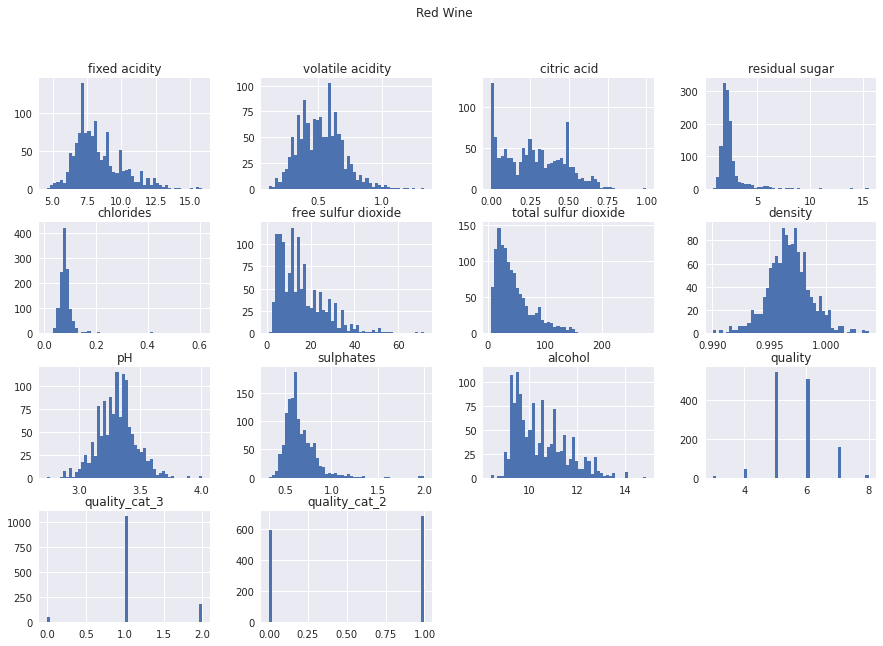

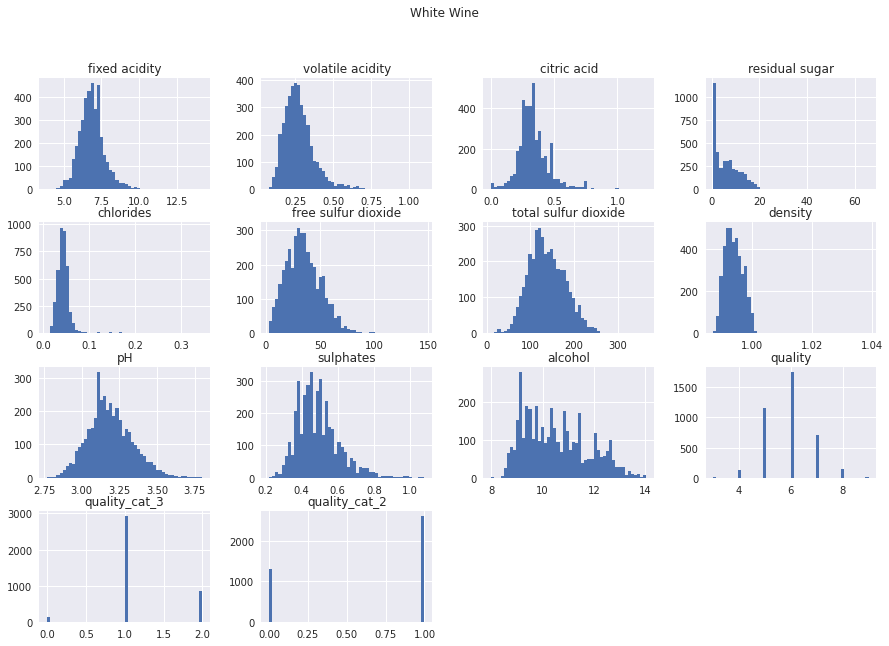

In [17]:
# View a histogram of each feature
for w in rw, ww:
    # Set plot style
    with plt.style.context('seaborn'):
        # Construct histogram with 50 bins for each feature
        hist = w.hist(bins=50, figsize=(15, 10))
        # Title for each set of histograms
        plt.gcf().suptitle(w.name)
    plt.show()

***

### View distribution of target variable
The target variable in this dataset is `quality`. As is obvious from the histograms above, the distribution of the output variable heavily favours the central categories. The red wine dataset is sorted into six ordinal categories from 3 to 8. Categories 5 and 6 represent over 80% of the data. The lowest category, 3, occurs in only 8 instances, representing 0.6% of the dataset; 4 occurs 42 times - 1.1% of total ratings. At the upper end of the scale 7 occurs 159 times or ~12% and just 15 red wines, ~1%, hold the highest rating of 8. 

The white wine dataset shows a similar imbalance. Of its 7 rating categories, 3 to 8, over 90% fall into the medium group, 5, 6, and 7. Categories 3 and 4 account for a combined 4% of instances, with just 16 wines with a rating of 3. Similarly, 8 and 9 occur in less than 4% of samples, with 9 only occurring 4 times.



In [18]:
# Count occurences of each quality class and calculate percents of total
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    # Count occurrences of each category
    wc = w.quality.value_counts()
    # Calculate percent of total number of samples
    wp = round(w.quality.value_counts() / len(w) * 100, 2)
    # Place in dataframe for ease of presentation and display
    df = pd.concat((wc,wp), axis=1)
    df.columns = ('Count', 'Percent')
    print(df)

-----------
Red Wine
-----------
   Count  Percent
5    545    42.61
6    510    39.87
7    159    12.43
4     42     3.28
8     15     1.17
3      8     0.63
-----------
White Wine
-----------
   Count  Percent
6   1758    44.87
5   1166    29.76
7    704    17.97
8    140     3.57
4    130     3.32
3     16     0.41
9      4     0.10


***

### View feature correlations

For each of the wine datasets (red and white), a correlation matrix is calculated using *pandas* `DataFrame.corr()` function. The correlation coefficient is calculated between each pair of numeric variables using Pearson's r. The resulting matrices are displayed as heatmaps using `seaborn.heatmap()`. The colourmap used is set to saturate at a correlation coefficient of 0.5 so that high correlations are very obvious. For the same reason the diagonal of the correlation matrix, which always holds a 1.0 as it is the value of a feature's correlation with itself, is removed.

The correlation heatmaps reveal the following:

- In the red wine dataset:
    - `Fixed acidity` is strongly correlated with each of `citric acid`, `density`, and `pH`
    - `Volatile acidity` is moderately correlated with `citric acid`
    - `Citric acid`, in addtion to it's correlations with `fixed acidity` and `volatile acidity`, also displays a moderate correlation with `pH`
    - `Total sulfur dioxide` and `free sulfur dioxide` are highly correlated
    - `Density` has a correlation of 0.49 with `alcohol`
    
- In the white wine dataset:
    - `Fixed acidity` is correlated with `pH`
    - `residual sugar` is highly correlated with `density` and, to a lesser extent, `alcohol`
    - `Total sulfur dioxide` and `free sulfur dioxide` are quite highly correlated
    - `Total sulfur dioxide` is also correlated with `density` and, more weakly with `alcohol`
    - `density`, in addition to its correlation with `residual sugar` and `total sulfur dioxide`, is highly correlated with `alcohol`

Finally, correlation with `quality` shows which attributes have the strongest influence on the output variable. These relationships are discussed below.

-----------
Red Wine
-----------


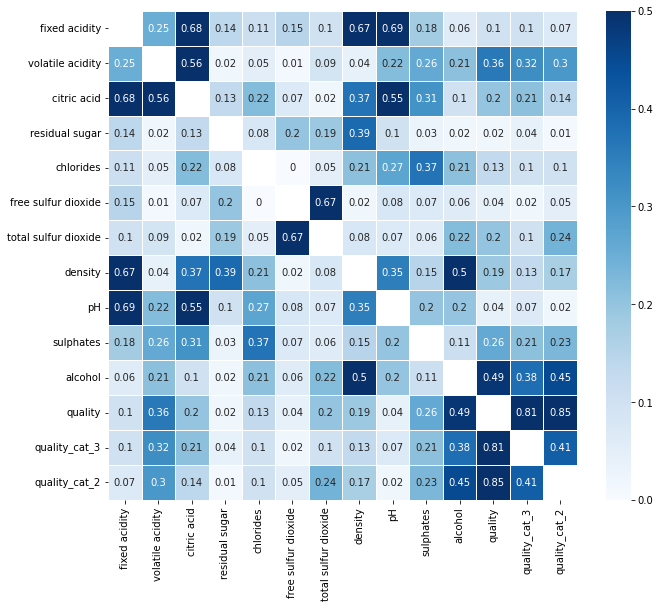

-----------
White Wine
-----------


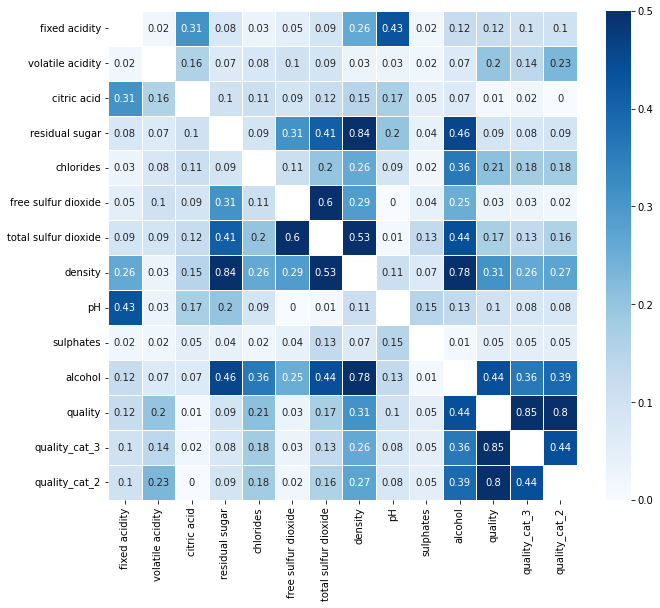

In [19]:
# Set figure size within context so it doesn't affect size of subsequent figures
with plt.rc_context({'figure.figsize':(10.5,9)}):
    # For each or red win and white wine dataframes
    for w in rw, ww:
        # Print the dataframe name
        print(f"-----------\n{w.name}\n-----------")
        # Calculate correlation matrix (using Pearson's r)
        corr = w.corr()
        # Remove distracting self correlations (always = 1)
        np.fill_diagonal(corr.values, 'NaN')
        # Display matrix as heatmap, saturate at 0.5 to make high correlations stand out
        sns.heatmap(abs(corr.round(2)), annot=True, linewidths=0.5, cmap='Blues', vmax=0.5)
        plt.show()

***

### Assess relative influence of each feature on the target variable

The tables below are the the `quality` columns from the correlation matrix calculated earlier, ordered (descending) by correlation coefficient. 

The features which influence red wine `quality` are dominated by `alcohol` and `volatile acidity`, with `sulphates`, `citric acid`, `total sulfur dioxide`, `density`, `chlorides`, and `fixed acidity` having moderate to low influences. `pH`, `free sulfur dioxide`, and `residual sugar` all have a very low correlation with wine quality. White wine `quality` is most influenced by `alcohol` and `density`. `Chlorides`, `volatile acidity`, `total sulfur dioxide`, and `fixed acidity` all exhibit a moderate influence, while `pH`, `residual sugar`, and `sulphates` show low correlation. The influences of `citric acid` and `free sulfur dioxide` are extremely low.

In [20]:
# Sort values in the correlation matrix by the absolute correlation with the target variable
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    # print the sorted absolute values of the correlation between each feature and quality
    print(abs(w.corr()['quality']).drop('quality').sort_values(ascending=False))

-----------
Red Wine
-----------
quality_cat_2           0.847727
quality_cat_3           0.812540
alcohol                 0.494687
volatile acidity        0.360708
sulphates               0.260455
total sulfur dioxide    0.200193
citric acid             0.200128
density                 0.187598
chlorides               0.125230
fixed acidity           0.098415
free sulfur dioxide     0.042583
pH                      0.035880
residual sugar          0.018032
Name: quality, dtype: float64
-----------
White Wine
-----------
quality_cat_3           0.850943
quality_cat_2           0.802534
alcohol                 0.443151
density                 0.311517
chlorides               0.212071
volatile acidity        0.202120
total sulfur dioxide    0.167789
fixed acidity           0.120259
pH                      0.095541
residual sugar          0.094968
sulphates               0.051432
free sulfur dioxide     0.026469
citric acid             0.010973
Name: quality, dtype: float64


***

## Feature scaling

Standardisation is the process of scaling data so that it has a mean of zero and unit variance. Many classification algorithms, including the RBF kernel of support vector machines, which may be used to classify this dataset, can be dominated by comparatively large values and are more likely to perform well on standardised data [11]. Similarly, KNN and logistic regression expect standardised data, as does PCA [8] [13]. As noted [above](#View-the-distribution-of-each-feature), a number of features have very long tails that can cause the majority of the data to be squeezed into a very small range. To counter this effect, scikit-learn provides a `RobustScaler()` which standardises the data based on the interquartile range (by default. The range used can be adjusted via `RobustScaler's` parameters). [14] [15]

In [21]:
# Instantiate StandardScaler and use to transform both datasets
scaler_std_rw = StandardScaler()
X_train_std_rw = scaler_std_rw.fit_transform(X_train_rw)
X_test_std_rw = scaler_std_rw.transform(X_test_rw)

scaler_std_ww = StandardScaler()
X_train_std_ww = scaler_std_ww.fit_transform(X_train_ww)
X_test_std_ww = scaler_std_ww.transform(X_test_ww)

# Instantiate RobustScaler and use to transform both datasets
scaler_rbst_rw = RobustScaler()
X_train_rbst_rw = scaler_rbst_rw.fit_transform(X_train_rw)
X_test_rbst_rw = scaler_rbst_rw.transform(X_test_rw)

scaler_rbst_ww = StandardScaler()
X_train_rbst_ww = scaler_rbst_ww.fit_transform(X_train_ww)
X_test_rbst_ww = scaler_rbst_ww.transform(X_test_ww)

# A look at the first row of each of the robust- and standard-
# scaled matrices for red wine show that the two scalers 
# produce quite different results
print(X_train_std_rw[0])
print(X_train_rbst_rw[0])

[-0.65006752 -0.19308698 -0.47818481  0.12612422 -0.39109757 -0.28278842
 -0.3823176  -0.02803301 -0.13276424 -1.05820583 -1.14378676]
[-0.3255814  -0.12371134 -0.24242424  0.71428571 -0.5        -0.07692308
 -0.075      -0.02197802 -0.10526316 -0.77777778 -0.625     ]


***

## Dimensionality reduction

The aim of dimensionality reduction is to reduce the number of input features and therefore the complexity of the problem while at the same time minimising the loss of variance between samples with different targets. There are a number of approaches to this, one of which is to simply drop features based on some criteria such as a immateriality to the problem or high correlation with another feature. Another approach entails the projection of high dimensional samples to lower dimensional space in a manner which maximises variance. This approach is exemplified by [principal components analysis (PCA)](#Principal-components-analysis-(PCA)) and [kernel PCA](#Kernel-PCA), which are considered below.

### Feature selection

Two approaches to feature selection are demonstrated in this section. Both have been placed in custom transformers. This will allow them to be placed in a pipeline later. It will also allow their parameters to be tuned using a grid search. Placing logic in a custom transformer is achieved by extending the `BaseEstimator` class and implementing the constructor (`__init__`) and the `fit()` and `transform()` methods. Adding the `TransformerMixin` provides the `fit_transform()` method.

The `DropLessImportantFeatures` transformer is instantiated with a single parameter, `threshold`, which defaults to 0.1. The `fit()` method calculates the correlation between each feature and the target variable using `numpy.corrcoef()`. The `transform` method then drops any features for which that correlation is less than the `threshold`.

In [22]:
# Custom Transformer for dropping features based on correlation with output variable
# Putting this functionality in a transformer allows it to be used in a pipeline and 
# grid/randomised search hyperparameter tuning
class DropLessImportantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.1):
        self.threshold=threshold

    def fit(self, X, y):
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        # X must be a numpy array
        # Calculate correlation coefficients, only keep the last one
        # because we only want each feature's correlation with y
        self.to_drop = abs(np.corrcoef(X, y, rowvar=False)[:,-1]) < self.threshold
        return self
    def transform(self, X):
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        # Remove columns (features) where correlation coefficient with
        # y (output variable) is lower than threshold
        return np.delete(X, self.to_drop[0:-1], axis=1)

In [23]:
# Use DropLessImportantFeatures transformer to drop features 
# with a correlation of less than 0.1 with the output variable 
# (quality) from the red and white wine datasets
dlif_rw = DropLessImportantFeatures()
X_train_rw_dlif = dlif_rw.fit_transform(X_train_rw, y_train_rw)
X_test_rw_dlif = dlif_rw.transform(X_test_rw)


dlif_ww = DropLessImportantFeatures()
X_train_ww_dlif = dlif_ww.fit_transform(X_train_ww, y_train_ww)

Examining the shape attribute of the red and white wine feature arrays shows that of the original 11 features in each dataset the red wine dataset has 7 and white has 6. The dropped columns are listed below. Note that because the ```random_state``` parameter in the ```train_test_split()``` call that produced these datasets was set, the results here are reproducible and can be commented on in specific terms. However, were the random number generator not seeded byt the ```random_state``` parameter, a different shuffle-split would occur on each execution of this notebook resulting in different attributes being retained and dropped here.   

In [24]:
# Print shape of new pruned arrays
print(f"Red wine dimensions:   {X_train_rw_dlif.shape}")
print(f"White wine dimensions: {X_train_ww_dlif.shape}\n")
# List the dropped columns
print("Dropped columns:")
print("----------------------------------------")
cols = zip_longest(X_train_rw.columns[dlif_rw.to_drop[0:-1]], 
           X_train_ww.columns[dlif_ww.to_drop[0:-1]])
print(tabulate(cols, headers=["Red wine", "White wine"]))
print("----------------------------------------")

Red wine dimensions:   (1279, 7)
White wine dimensions: (3918, 6)

Dropped columns:
----------------------------------------
Red wine             White wine
-------------------  -------------------
fixed acidity        citric acid
residual sugar       residual sugar
free sulfur dioxide  free sulfur dioxide
pH                   pH
                     sulphates
----------------------------------------


We can also try removing one of every pair of strongly correlated features. While in some ways this may be a naive mode of dimensionality reduction, it may be appropriate in some cases, particularly where it is desirable to keep the original features so that each feature's level of importance to a classification can be assessed.

The `DropCorrelatedFeatures` transformer is instantiated with a single parameter, `threshold`, which defaults to 0.5. The `fit` method calculates the absolute correlation matrix, using `numpy.corrcoef()`, for the passed array. The self-correlations along the diagonal of the matrix are set to 0. For each feature, the number of other features that it shares a greater-than-the-`threshold` correlation with is noted and the feature with the greatest number of correlations is removed. The correlation matrix is again calculated on the remaining features and the process repeated until no correlations greater than the threshold remain.

In [25]:
# Custom Transformer for dropping features based on correlation with output variable
# Putting this functionality in a transformer allows it to be used in a pipeline and 
# grid/randomised search hyperparameter tuning
class DropCorrelatedFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.5):
        self.threshold=threshold

    def fit(self, X, y=None):        
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        # X should be a numpy array
        # Make temp copy of X
        c = X.copy()
        
        # Calculate absolute correlation matrix for all input features
        # Loop control variable
        max_sums = -1
        # List to hold indexes of features to drop
        idxs = []
        # Loop until there are no correlations above the threshold
        while max_sums != 0:
            # Calculate absolute correlation matrix
            corr = abs(np.corrcoef(c, rowvar=False))
            # Fill diagonal with zeroes
            np.fill_diagonal(corr, 0)
            # construct boolean matrix based on threshold 
            corr = corr >= self.threshold
            # calculate number of features that correlate with each feature
            sums = np.sum(corr, axis=1)
            if max(sums) != 0:
                # get index of max value
                idx = np.argmax(sums)
                # Index in original array will not always match index in current 
                # array as one column is deleted on each iteration
                # If the new index is less than the last index then it can be used unchanged
                if len(idxs) > 0 | idx < idxs[-1]:
                    idxs.append(idx)
                # otherwise the number of removed columns must be added
                else:
                    idxs.append(idx+len(idxs))
                # Delete the column at the current index from the temporary array
                c = np.delete(c, idx, axis=1)
                # update the loop variable
            max_sums = max(sums)

        self.idxs = idxs
        return self
    
    def transform(self, X):
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        # Remove columns (features) which correlate over the threshold with other features
        return np.delete(X, self.idxs, axis=1)


In [26]:
# Use DropCorrelatedFeatures transformer to drop features 
# with a correlation of greater than or equal to 0.5 with 
# with any other feature from the red and white wine datasets
dcf_rw = DropCorrelatedFeatures()
X_train_rw_dcf = dcf_rw.fit_transform(X_train_rw)
X_test_rw_dcf = dcf_rw.transform(X_test_rw)

dcf_ww = DropCorrelatedFeatures()
X_train_ww_dcf = dcf_ww.fit_transform(X_train_ww)

With a correlation threshold of 0.5, the red wine dataset drops three columns, and the white wine dataset two.

In [27]:
# Print shape of new pruned arrays
print(f"Red wine dimensions:   {X_train_rw_dcf.shape}")
print(f"White wine dimensions: {X_train_ww_dcf.shape}\n")
# List the dropped columns
print("Dropped columns:")
print("----------------------------------------")
cols = zip_longest(X_train_rw.columns[dcf_rw.idxs], 
           X_train_ww.columns[dcf_ww.idxs])
print(tabulate(cols, headers=["Red wine", "White wine"]))
print("----------------------------------------")

Red wine dimensions:   (1279, 8)
White wine dimensions: (3918, 9)

Dropped columns:
----------------------------------------
Red wine             White wine
-------------------  --------------------
fixed acidity        density
citric acid          total sulfur dioxide
free sulfur dioxide
----------------------------------------


### Principal components analysis (PCA)

Principal components analysis reduces the dimensionality of a dataset by identifying the axis that preserves the maximum variance in each dimension of the data and projecting the data on those axes to a lower number of dimensions [4 p.20-23]. Scikit-learn's `PCA` class allows the number of desired dimensions to be specified via the `n_components` attribute. A float between 0.0 and 1.0 passed to `n_components` will be interpreted as the amount of variance to be preserved and the number of principal components necessary for this will be automatically selected.

In [28]:
# Conduct PCA on the robust-standardised datasets, preserving 95% of variance
pca_rw = PCA(n_components=0.95)
pca_ww = PCA(n_components=0.95)
X_train_pca_rw = pca_rw.fit_transform(X_train_rbst_rw)
X_train_pca_ww = pca_ww.fit_transform(X_train_rbst_ww)

Transforming the robustly standardised datasets with `PCA`, preserving 95% of variance produces a 7 dimension red wine dataset and a 9 dimension white wine dataset.

In [29]:
print(X_train_pca_rw.shape)
print(X_train_pca_ww.shape)

(1279, 7)
(3918, 9)


### Kernel PCA

Kernel PCA is an algorithm that can be used to reduce dimensionality in complex datasets. Its output is a specified number of components. Unlike PCA, the percentage of variance preserved cannot be specified. Commonly adjusted parameters are kernel type and, if using a `poly`, `rbf`, or `sigmoid` kernel, gamma.

In [30]:
# [8] Kernel PCA
# Calculate the first three principal components of each dataset using 
# KernelPCA with rbf kernel
kpca_rw = KernelPCA(n_components=3, kernel="rbf", gamma=0.04)
X_train_kpca_rw = kpca_rw.fit_transform(X_train_rbst_rw)

kpca_ww = KernelPCA(n_components=3, kernel="rbf", gamma=0.04)
X_train_kpca_ww = kpca_ww.fit_transform(X_train_rbst_ww)

In [31]:
print(X_train_kpca_rw.shape)
print(X_train_kpca_ww.shape)

(1279, 3)
(3918, 3)


## Model selection

As mentioned [previously](#The-Wine-Quality-Dataset), the wine quality dataset can be cast as a regression problem or as a classification problem. As a regression problem the `quality` column can be viewed as a continuous variable with a range from the lowest to the highest rating. As a classification problem each rating can be considered a different class. It is expected that the [very low numbers](#View-distribution-of-target-variable) of extreme classifications will make training difficult in these classes. A possible solution to this is to merge some of the classes as has been done in the creation of the [`quality_cat`](#Split-the-data) target columns.

It is proposed to fit a number of estimators to the dataset and to compare results. First, a linear regression will be performed on the dataset using, as targets, the quasi-continous 8-9 category original ordinal quality values. Next two classifications will be performed on dataset using each of the 2- and 3-category quality columns as targets. The classification algorithms used will be support vector machines and a random forest classifier, as both of these have been noted to have met with some success in classifying this dataset in the past.

## Pipelines

Organisation of a series of transforms prior to a final estimator is aided by the `sklearn.pipeline.Pipeline` class. This allows a list of named steps to be assembled which are executed on the data consecutively. Usually this would consist of a series of transforms followed by a fit but the `Pipeline` class is very flexible and this is not the only possible configuration [16]. Pipelines are particularly useful in the context of hyperparameter tuning using grid search.

### Linear Regression
Here a linear regression is performed on the wine quality data.

In [32]:
def linreg(X_train, y_train, X_test, y_test, name=''):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)
    print(name)
    print("-" * len(name))
    print(f"Intercept: {lr.intercept_:.2f}")
    print(f"R2: {lr.score(X_train, y_train):.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 test: {r2:.2f}")
    print("--------------")
    return pred

p_rw = linreg(X_train_rw, y_train_rw, X_test_rw, y_test_rw, name='Red Wine')
p_ww = linreg(X_train_ww, y_train_ww, X_test_ww, y_test_ww, name='White Wine')



Red Wine
--------
Intercept: 1.67
R2: 0.37
MSE: 0.43
RMSE: 0.66
R2 test: 0.33
--------------
White Wine
----------
Intercept: 135.04
R2: 0.30
MSE: 0.62
RMSE: 0.79
R2 test: 0.21
--------------


These results seem good. MSE is very low but R2 is also low meaning the model doesn't explain a huge proportion of the variance. However, it has been suggested that a low R2 doesn't necessarily indicate a bad model [20]. It might be instructive to treat the problem as a classification problem for a moment, and to assess the linear regression using classification metrics.

Red Wine
--------


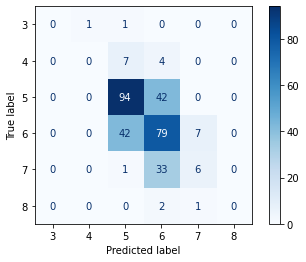

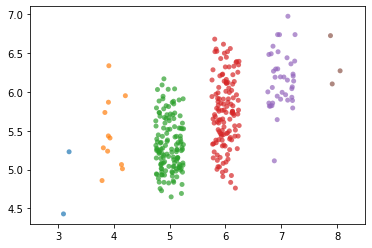

Precision: 0.5265886699507389
Recall: 0.559375
f1: 0.5315638592328983

White Wine
----------


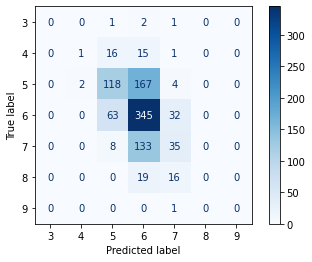

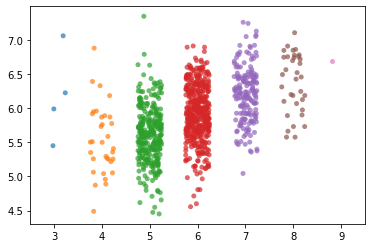

Precision: 0.47861352430569193
Recall: 0.5091836734693878
f1: 0.4664896181020902



In [33]:
def lr_tests(a, p, name):    
    # Sort actual and predicted values by actual value, convert both to list, and round predicted values and cast to int
    actual, predicted = zip(*sorted(zip(a.tolist(), np.round(p).astype(int).tolist()), reverse=True))

    print(f"{name}")
    print("-" * len(f"{name}"))
    ConfusionMatrixDisplay.from_predictions(actual, predicted, 
                                            cmap=plt.cm.Blues, 
                                            normalize=None)

    plt.show()

    sns.stripplot(x=list(a), y=p, jitter=0.25, alpha=0.7)
    plt.show()

    precision = precision_score(actual, predicted, average='weighted', zero_division=0)
    recall = recall_score(actual, predicted, average='weighted')
    f1 = f1_score(actual, predicted, average='weighted')
    print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}\n")


lr_tests(y_test_rw, p_rw, 'Red Wine')
lr_tests(y_test_ww, p_ww, 'White Wine')

The linear regression seems to have produced quite poor results in spite of its low MSE. R2 score is probably a better metric to use after all as is illustrated by the dummy regressor instantiated below. This regressor always returns the mean of the dataset - so each prediction it makes produces the same result. DOing this it manages to produce MSEs of 0.65 for the red wine data and 0.79 for the white.

In [34]:
def dummyreg(X_train, y_train, X_test, y_test, name=''):
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(X_train, y_train)
    pred = dummy.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)
    print(name)
    print("-" * len(name))
    print(f"R2: {dummy.score(X_train, y_train):.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 test: {r2:.2f}")
    print("--------------")
    return pred

p_rw = dummyreg(X_train_rw, y_train_rw, X_test_rw, y_test_rw, name='Red Wine')
p_ww = dummyreg(X_train_ww, y_train_ww, X_test_ww, y_test_ww, name='White Wine')

Red Wine
--------
R2: 0.00
MSE: 0.65
RMSE: 0.80
R2 test: -0.00
--------------
White Wine
----------
R2: 0.00
MSE: 0.79
RMSE: 0.89
R2 test: -0.00
--------------


Perhaps some preprocessing of the data will help. Below, a Pipeline and cross validation grid search is used to see if scaling the data before conducting the linear regression will produce better results. Three scaling algorithms are tested; StandardScaler, which transforms the dataset so that the mean is zero and the variance 1; RobustScaler(), which is robust to outliers because it transforms the dataset so that the median is zero and the data is scaled within the interquartile range.

In [35]:
# Test if scaling is necessary
pipe = Pipeline([
    ('std', StandardScaler()),
    ('rbst', RobustScaler()),
    ('minmax', MinMaxScaler()),
    ('lr', LinearRegression())
])

# This will also test combinations of scalers which is poitnless but does no harm
params = [
    {'std': ['passthrough', StandardScaler()],
     'rbst': ['passthrough', RobustScaler(quantile_range=(1,99))],
     'minmax': ['passthrough', MinMaxScaler()]
     }
] 

gs = GridSearchCV(pipe, params, cv=5, scoring='r2')

gs.fit(X_train_rw, y_train_rw)
rw_scores = gs.cv_results_['mean_test_score']

gs.fit(X_train_ww, y_train_ww)
ww_scores = gs.cv_results_['mean_test_score']

print(f"Red wine scores: {rw_scores}")
print(f"White wine scores: {ww_scores}")
    

Red wine scores: [0.34302329 0.34302329 0.34302329 0.34302329 0.34302329 0.34302329
 0.34302329 0.34302329]
White wine scores: [0.29093409 0.29093409 0.29093409 0.29093409 0.29093409 0.29093409
 0.29093409 0.29093409]


The scores above are identical to the scores obtained by the regression on the original unscaled data so scaling seems to have had no effect whatsoever. Next, the effect of dropping features based on high correlation with other features or on low correlation with the target attribute will be investigated. Again, a Pipeline / cross-validated grid search is used to quickly assess a number of combinations of parameters.

In [36]:
# Drop features pipeline
pipe = Pipeline([
    ('dlif', DropLessImportantFeatures()),
    ('dcf', DropCorrelatedFeatures()),
    ('lr', LinearRegression())
])

params = [
    # A dlif threshold of 0 is equivalent to bypassing the transformer
    {'dlif__threshold': [0, 0.1, 0.2],
    # A dcf threshold of 1 is equivalent to bypassing the transformer
    'dcf__threshold': [0.5, 0.6, 0.7, 0.8, 0.9, 1]}
]

def gridsearch_wine_lr(pipe,params):
    gs = GridSearchCV(pipe, params, cv=5, scoring='r2')

    # Fit the model to the training data
    gs.fit(X_train_rw, y_train_rw)
    # Extract the best parameters and the best score
    rw_est = gs.best_estimator_
    rw_score = gs.best_score_

    # Fit the model to the training data
    gs.fit(X_train_ww, y_train_ww)
    # Extract the best parameters and the best score
    ww_est = gs.best_estimator_
    ww_score = gs.best_score_

    print(f"Red wine best score: {rw_score}")
    print(f"Red wine best estimator: {rw_est}")
    print(f"White wine best score: {ww_score}")
    print(f"White wine best estimator: {ww_est}")

gridsearch_wine_lr(pipe, params)


Red wine best score: 0.3431885909170673
Red wine best estimator: Pipeline(steps=[('dlif', DropLessImportantFeatures(threshold=0)),
                ('dcf', DropCorrelatedFeatures(threshold=0.6)),
                ('lr', LinearRegression())])
White wine best score: 0.290934089594513
White wine best estimator: Pipeline(steps=[('dlif', DropLessImportantFeatures(threshold=0)),
                ('dcf', DropCorrelatedFeatures(threshold=0.9)),
                ('lr', LinearRegression())])


The red wine regression performs marginally better when features with a correlation coefficient greater than 0.6 are dropped but the white saw no improvement from dropping features. Lastly, the effects of dimensionality reduction by means of PCA is investigated.

In [37]:
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('lr', LinearRegression())
])

params = [{
    'pca__n_components': [0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5]
}]

gridsearch_wine_lr(pipe, params)


Red wine best score: 0.04643949580286359
Red wine best estimator: Pipeline(steps=[('pca', PCA(n_components=0.99)), ('lr', LinearRegression())])
White wine best score: 0.05465594054968563
White wine best estimator: Pipeline(steps=[('pca', PCA(n_components=0.99)), ('lr', LinearRegression())])


PCA significantly reduces the R2 score. The best results were obtained by dropping some higly correlated features from the red wine dataset and by conducting linear regression on the white wine dataset without any preprocessing. Even the improvement obtained in the red wine results is negligible. Perhaps the problem will yield to treatment as a classification problem.

Finally, to close the linear regression section of this notebook, a demonstration of the ease with which different algorithms can be assessed for suitability to a problem. Here, three regularised linear models are imported, fit to each of the two wine datasets, tested and output metrics calculated. Note that this is done with just a few lines of code, and using exactly the same method for each algorithm; ```fit``` and ```predict```. The only difference between the algorithm implementations is the parameters they accept.

In [38]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

print("Some linear models")
print("------------------")
for w in ('rw', 'ww'):
     
    # Set the variables depending on dataset    
    (X_train, y_train, X_test, y_test) = \
        (X_train_rw, y_train_rw, X_test_rw, y_test_rw) if w == 'rw' \
        else (X_train_ww, y_train_ww, X_test_ww, y_test_ww)
    name = 'Red Wine' if w == 'rw' else 'White Wine'
    
    print('-' * len(name))
    print(name)
    print('-' * len(name))
    
    # Ridge regression
    rr = Ridge(alpha=1.0)
    rr.fit(X_train, y_train)
    pred = rr.predict(X_test)
    r2 = r2_score(y_test, pred)
    print("Ridge regression")
    print(f"r2 score: {r2}")
    print("----------------")

    # Lasso regression
    lasso_r = Lasso(alpha=0.001)
    lasso_r.fit(X_train_ww, y_train_ww)
    pred = lasso_r.predict(X_test_ww)
    r2 = r2_score(y_test_ww, pred)
    print("Lasso regression")
    print(f"r2 score: {r2}")
    print("----------------")
    
    # ElasticNet regression
    elastic_r = ElasticNet(alpha=0.001, l1_ratio=0.5)
    elastic_r.fit(X_train_ww, y_train_ww)
    pred = elastic_r.predict(X_test_ww)
    r2 = r2_score(y_test_ww, pred)
    print("ElasticNet regression")
    print(f"r2 score: {r2}")
    print("----------------")

Some linear models
------------------
--------
Red Wine
--------
Ridge regression
r2 score: 0.3316768574234161
----------------
Lasso regression
r2 score: 0.2011575978058069
----------------
ElasticNet regression
r2 score: 0.2015831018902141
----------------
----------
White Wine
----------
Ridge regression
r2 score: 0.20103897556601436
----------------
Lasso regression
r2 score: 0.2011575978058069
----------------
ElasticNet regression
r2 score: 0.2015831018902141
----------------


### Classification using SVM and random forest

Before commencing classification, it is useful to classify the data using a dummy classifier that always outputs the most common value. This is especially important in the case of the 3 category classification because the medium category contains so many more values than the high or low. The cell below fits a dummy classifer that always classifies wines as medium quality to the red and white wine datasets using the 3 category target dataset, and a dummy classifier that always classifies a wine as high (or '1') to the 2 catgory targets. This cell also serves as an introduction to the metrics that will be used to assess the quality of a classification. 

First, a confusion matrix is generated, which graphically illustrates all of the correct and mis-classifications. Then, precision, recall, and f1 are calculated. Precision is the number of true positive classification instances divided by the total number of classificaiton attempts - i.e. $$P=\frac{TP}{TP+FP}\\
\text{where P = precision, TP = the number of true positives, and FP is the number of false positives}$$
Recall is the number of true positives divided by the number of true postives plus the number of false negatives, or $$R=\frac{TP}{TP+FN}\\
\text{where R = recall, TP = the number of true positives, and FN is the number of false negatives}$$
The $F_1$ score is the harmonic mean of precision and recall, which means that if both precision *and* recall are high then $F_1$ will be high [4 p.92]. The $F1$ will be the primary metric by which the classifications will be compared.

Looking at the output from the dummy classifiers below, the 3-category red wine dummy classifier enjoys an $F_1$ of 0.75, with a very high recall, that rests entirely on the structure of the dataset of 0.83. The 3-category white wine dummy classifier produces calssifications with an $F_1$ of 0.64. The 2-category dummy classifiers are less successful as the datasets are much more evenly distributed across their two categories; the red wine $F_1$ is 0.37 and the white is 0.53.

3 Category Red Wine
-------------------


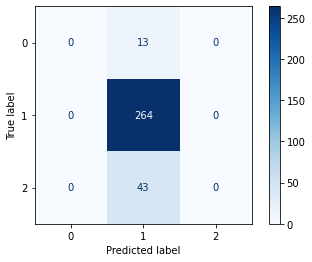

Precision: 0.6806249999999999
Recall: 0.825
f1: 0.7458904109589041
2 Category Red Wine
-------------------


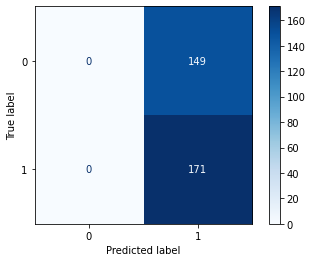

Precision: 0.285556640625
Recall: 0.534375
f1: 0.3722123217922607
3 Category White Wine
---------------------


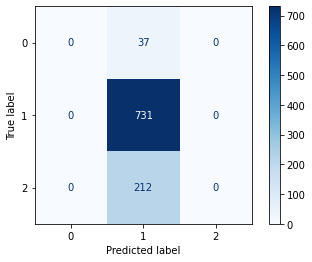

Precision: 0.5563942107455226
Recall: 0.7459183673469387
f1: 0.6373656651439067
2 Category White Wine
---------------------


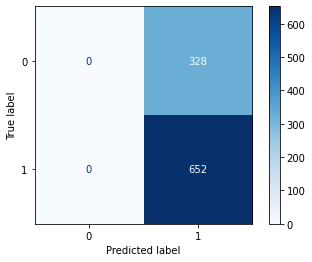

Precision: 0.44263223656809664
Recall: 0.6653061224489796
f1: 0.5315926370548218


In [64]:
# Calculate the confusion matrix, precision, recall, f1, and print
def metrics(y_test, y_pred, name, confusion=True):
    # Calculate the metrics and print
    print(name)
    print("-" * len(name))
    # Calculate the confusion matrix
    if confusion:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                            #display_labels=['low', 'medium', 'high'], 
                                            cmap=plt.cm.Blues, 
                                            normalize=None)
        plt.grid(False)
        plt.show()

    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}")

# Classify both wine datasets with the dummy classifier
for w in ('rw', 'ww'):

    # ensure the variables are pointing to the correct datasets
    X_train = X_train_rw if w == 'rw' else X_train_ww
    X_test = X_test_rw if w == 'rw' else X_test_ww
    y_train_cat3 = y_train_cat3_rw if w == 'rw' else y_train_cat3_ww
    y_test_cat3 = y_test_cat3_rw if w == 'rw' else y_test_cat3_ww
    y_train_cat2 = y_train_cat2_rw if w == 'rw' else y_train_cat2_ww
    y_test_cat2 = y_test_cat2_rw if w == 'rw' else y_test_cat2_ww
    name = 'Red Wine' if w == 'rw' else 'White Wine'

    # The dummy classifier always returns 1
    dummy = DummyClassifier(strategy='constant', constant=1)

    # Fit to 3 category data and predict on test data
    dummy.fit(X_train, y_train_cat3)
    pred = dummy.predict(X_test)
    metrics(y_test_cat3, pred, f"3 Category {name}", confusion=True)

    # Fit to 2 category data and predict on test data
    dummy.fit(X_train, y_train_cat2)
    pred = dummy.predict(X_test)
    metrics(y_test_cat2, pred, f"2 Category {name}")

Using the SVC classifier - a classifier based on support vector machines the can be useful for classification of small, complex datasets [4 p.153] - a pipeline is constructed and a cross-validated hyperparameter grid search is conducted to assess what, if any, preprocessing steps, as well as what SVC hyperparameter settings, will achieve the best classification. Because this is a very long-running - and not particularly fruitful - search, the ```fit``` line has been commented out. However the optimal hyperparameters for the 3-category red wine data are shown below. Note that because StandardScaler() hasn't been passed through the data has been scaled with that scaler.

```python
# Best params from very long gridsearch
# including PCA with varying numbers of 
# components on 3 category data
{'clf__C': 1,
 'clf__gamma': 1,
 'clf__kernel': 'rbf',
 'pca': 'passthrough',
 'rbst': 'passthrough'}
```

In [40]:
pipe = Pipeline([
    ('std', StandardScaler()),
    ('rbst', RobustScaler()),
    ('pca', PCA(n_components=0.95)),
    ('clf', SVC(kernel='rbf', gamma=0.1, C=1))
])

params = [{
    # Param search with robust scaling and PCA
    'std': ['passthrough'],
    'pca__n_components': [4, 5, 6],
    'clf__kernel': ['rbf', 'poly'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': [1, 0.1, 0.01]
},{
    # Param search with standard scaling and PCA
    'rbst': ['passthrough'],
    'pca__n_components': [4, 5, 6],
    'clf__kernel': ['rbf', 'poly'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': [1, 0.1, 0.01]
},{
    # Param search with standard scaling without PCA
    'rbst': ['passthrough'],
    'pca': ['passthrough'],
    'clf__kernel': ['rbf', 'poly'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': [1, 0.1, 0.01]
},{
    # Param search with robust scaling without PCA
    'std': ['passthrough'],
    'pca': ['passthrough'],
    'clf__kernel': ['rbf', 'poly'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': [1, 0.1, 0.01]
}]

gs = GridSearchCV(pipe, params, cv=5, error_score='raise')
# gs.fit(X_train_rw, y_train_cat3_rw)

It seems that dimensionality reduction is unhelpful in this instance so now classification can proceed using the best parameters.

2 Category Red Wine
-------------------


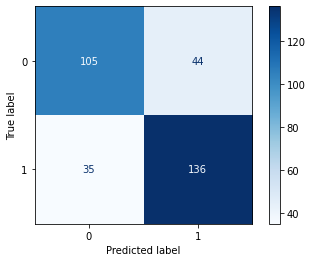

Precision: 0.75296875
Recall: 0.753125
f1: 0.7524459897081005
3 Category Red Wine
-------------------


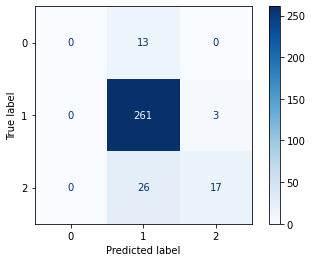

Precision: 0.83196875
Recall: 0.86875
f1: 0.8360836710570754
2 Category White Wine
---------------------


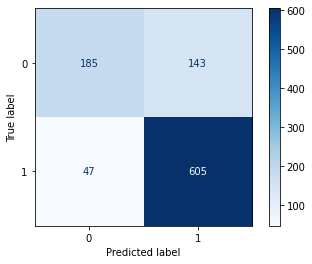

Precision: 0.8050047605248997
Recall: 0.8061224489795918
f1: 0.7961516034985421
3 Category White Wine
---------------------


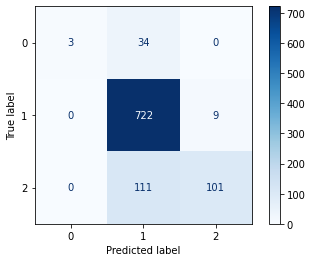

Precision: 0.8575506566262868
Recall: 0.8428571428571429
f1: 0.8154050819482015


In [65]:
# The pipeline for SVC classifications of the categorical wine data
pipe = Pipeline([
    ('std', StandardScaler()),
    ('clf', SVC(kernel='rbf', gamma=1, C=1))
])

# 2 category red wine
pipe.fit(X_train_rw, y_train_cat2_rw)
pred = pipe.predict(X_test_rw)
metrics(y_test_cat2_rw, pred, "2 Category Red Wine", confusion=True)

# 3 category red wine
pipe.fit(X_train_rw, y_train_cat3_rw)
pred = pipe.predict(X_test_rw)
metrics(y_test_cat3_rw, pred, "3 Category Red Wine", confusion=True)

# 2 category white wine
pipe.fit(X_train_ww, y_train_cat2_ww)
pred = pipe.predict(X_test_ww)
metrics(y_test_cat2_ww, pred, "2 Category White Wine", confusion=True)

# 3 category white wine
pipe.fit(X_train_ww, y_train_cat3_ww)
pred = pipe.predict(X_test_ww)
metrics(y_test_cat3_ww, pred, "3 Category White Wine", confusion=True)

The $F_1$ scores achieved by the SVC classifier were signifcantly better than those achieved by the dummy classifier:

|Dataset | Dummy  | Actual    | 
|:---|-------------:|-----------:|
| 2 category red wine| 0.37  | 0.75       | 
| 3 category red wine | 0.75  | 0.84   | 
| 2 category white wine| 0.53  | 0.80      | 
| 3 category white wine | 0.63  | 0.82    |

However, none was very reliable, particularly the three-category classifiers which failed extremelt requently to identify low and high quality wines.

Finally, a random forest classifier is assessed. First a grid search is conducted to find the best parameters.

In [93]:
pipe = Pipeline([
    ('clf', RandomForestClassifier(n_jobs=-1)),
])

params = {
    'clf__n_estimators': [10, 25, 50, 100, 200, 400]
}

for w in ('rw', 'ww'):
    # ensure the variables are pointing to the correct datasets
    X_train = X_train_rw if w == 'rw' else X_train_ww
    X_test = X_test_rw if w == 'rw' else X_test_ww
    y_train_cat3 = y_train_cat3_rw if w == 'rw' else y_train_cat3_ww
    y_test_cat3 = y_test_cat3_rw if w == 'rw' else y_test_cat3_ww
    y_train_cat2 = y_train_cat2_rw if w == 'rw' else y_train_cat2_ww
    y_test_cat2 = y_test_cat2_rw if w == 'rw' else y_test_cat2_ww
    name = 'Red Wine' if w == 'rw' else 'White Wine'

    # Fit to 3 category data and print parameters that echieved the best score
    gs = GridSearchCV(pipe, params, cv=5, scoring='balanced_accuracy', error_score='raise')
    gs.fit(X_train, y_train_cat3)
    print(f"Best parameters for 3 category {name}: {gs.best_params_}")
    print(f"Best score for 3 category {name}: {gs.best_score_}")

    # Fit to 2 category data and print parameters that echieved the best score
    gs = GridSearchCV(pipe, params, cv=5, scoring='accuracy', error_score='raise')
    gs.fit(X_train, y_train_cat2)
    print(f"Best parameters for 2 category {name}: {gs.best_params_}")
    print(f"Best score for 2 category {name}: {gs.best_score_}")


Best parameters for 3 category Red Wine: {'clf__n_estimators': 25}
Best score for 3 category Red Wine: 0.5145639677672016
Best parameters for 2 category Red Wine: {'clf__n_estimators': 200}
Best score for 2 category Red Wine: 0.8154564950980392
Best parameters for 3 category White Wine: {'clf__n_estimators': 400}
Best score for 3 category White Wine: 0.5522329339716491
Best parameters for 2 category White Wine: {'clf__n_estimators': 400}
Best score for 2 category White Wine: 0.8272131649594705


The cross validation grid search for random forest classifier parameters indicate that accuracy will be similar to those achieved by the SVC classifier. The much lower accuracy scores for the 3 category datasets is due to a stricter 'balanced accuracy' scoring method used by the grid search to pick the best performimg parameter set [21]. All that remains is for the classification to be conducted and the results assessed:

2 Category Red Wine
-------------------


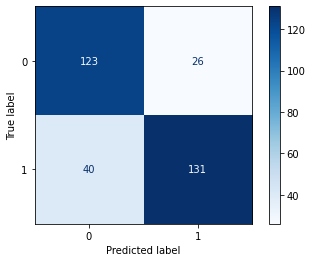

Precision: 0.7972409733890821
Recall: 0.79375
f1: 0.7939757270168855
3 Category Red Wine
-------------------


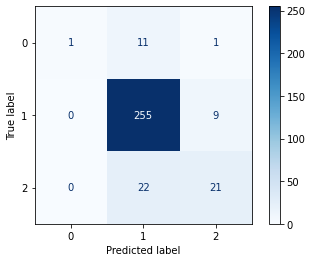

Precision: 0.8621219758064516
Recall: 0.865625
f1: 0.8442987241900285
2 Category White Wine
---------------------


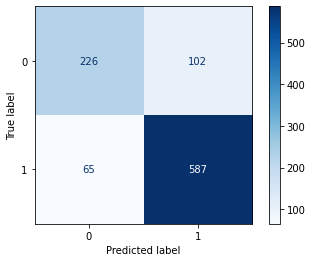

Precision: 0.826747855936174
Recall: 0.8295918367346938
f1: 0.8268497581653835
3 Category White Wine
---------------------


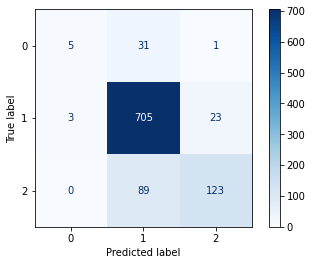

Precision: 0.8420260024232328
Recall: 0.85
f1: 0.8325535131788118


In [94]:
# Intialize the random forest classifiers using results from grid search
clf_rwcat2 = RandomForestClassifier(n_estimators=200, n_jobs=-1)
clf_rwcat3 = RandomForestClassifier(n_estimators=25, n_jobs=-1)
clf_wwcat2 = RandomForestClassifier(n_estimators=400, n_jobs=-1)
clf_wwcat3 = RandomForestClassifier(n_estimators=400, n_jobs=-1)

# 2 category red wine
clf_rwcat2.fit(X_train_rw, y_train_cat2_rw)
pred = clf_rwcat2.predict(X_test_rw)
metrics(y_test_cat2_rw, pred, "2 Category Red Wine", confusion=True)

# 3 category red wine
clf_rwcat3.fit(X_train_rw, y_train_cat3_rw)
pred = clf_rwcat3.predict(X_test_rw)
metrics(y_test_cat3_rw, pred, "3 Category Red Wine", confusion=True)

# 2 category white wine
clf_wwcat2.fit(X_train_ww, y_train_cat2_ww)
pred = clf_wwcat2.predict(X_test_ww)
metrics(y_test_cat2_ww, pred, "2 Category White Wine", confusion=True)

# 3 category white wine
clf_wwcat3.fit(X_train_ww, y_train_cat3_ww)
pred = clf_wwcat3.predict(X_test_ww)
metrics(y_test_cat3_ww, pred, "3 Category White Wine", confusion=True)

The Random forest classifer performed a little better than the SVC, and had less trouble with low and high values. Further tuning and preprocessing might result in a useful classifier. It is suspected, however, that the highly imbalanced nature of the dataset, combined with the potentially arbitrary and subjective nature of a quality rating make this a very difficult dataset to classify with great accuracy, and that it will never be classifiable to the same degree of accuracy that measurable observeable phenomena can be.

***
***

## References
[0] Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J., 2009, Wine quality data: Data set description [online]. Available from https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names. Accessed 25-11-21.

[1] Buitinck, L., Louppe, G., Blondel, M., Pedregosa, F., Mueller, A., Grisel, O.,Niculae, V., Prettenhofer, P., Gramfort, A., Grobler, J., Layton, R., VanderPlas, J., Joly, A., Holt, B., Varoquaux, G., 2013, API design for machine learning software: experiences from the scikit-learn project, arXiv:1309.0238.

[-1] Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J., 2009, Modeling wine preferences by data mining from physicochemical properties, Decision Support Systems 47(4):547-553. doi:10.1016/j.dss.2009.05.016 

[2] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

[3] Scikit-learn developers, https://scikit-learn.org/stable/modules/preprocessing.html

[4] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol

[5] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

[6] Should we apply normalization to test data as well? https://datascience.stackexchange.com/a/27616

[7] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:223

[8] https://stats.stackexchange.com/a/69159 Why do we need to normalize data before principal component analysis (PCA)?

[9] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:227

[10] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:233  #### LDA good to reduce dimensionality before another classifcation algorithm such as SVM

[11] https://scikit-learn.org/stable/modules/preprocessing.html Standardization, or mean removal and variance scaling

[12] https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html sklearn.discriminant_analysis.LinearDiscriminantAnalysis "The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix."

[13] https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

[14] https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#standardscaler

[15] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

[16] https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

[17] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[18] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol: p: 220-221, 226-117

[19] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol: p: 220-223

[20] Ford, C., 2015, Is R-squared useless? [online] Available at https://data.library.virginia.edu/is-r-squared-useless/. Accessed 20-11-21.

[21] https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score
